# Graph RAG

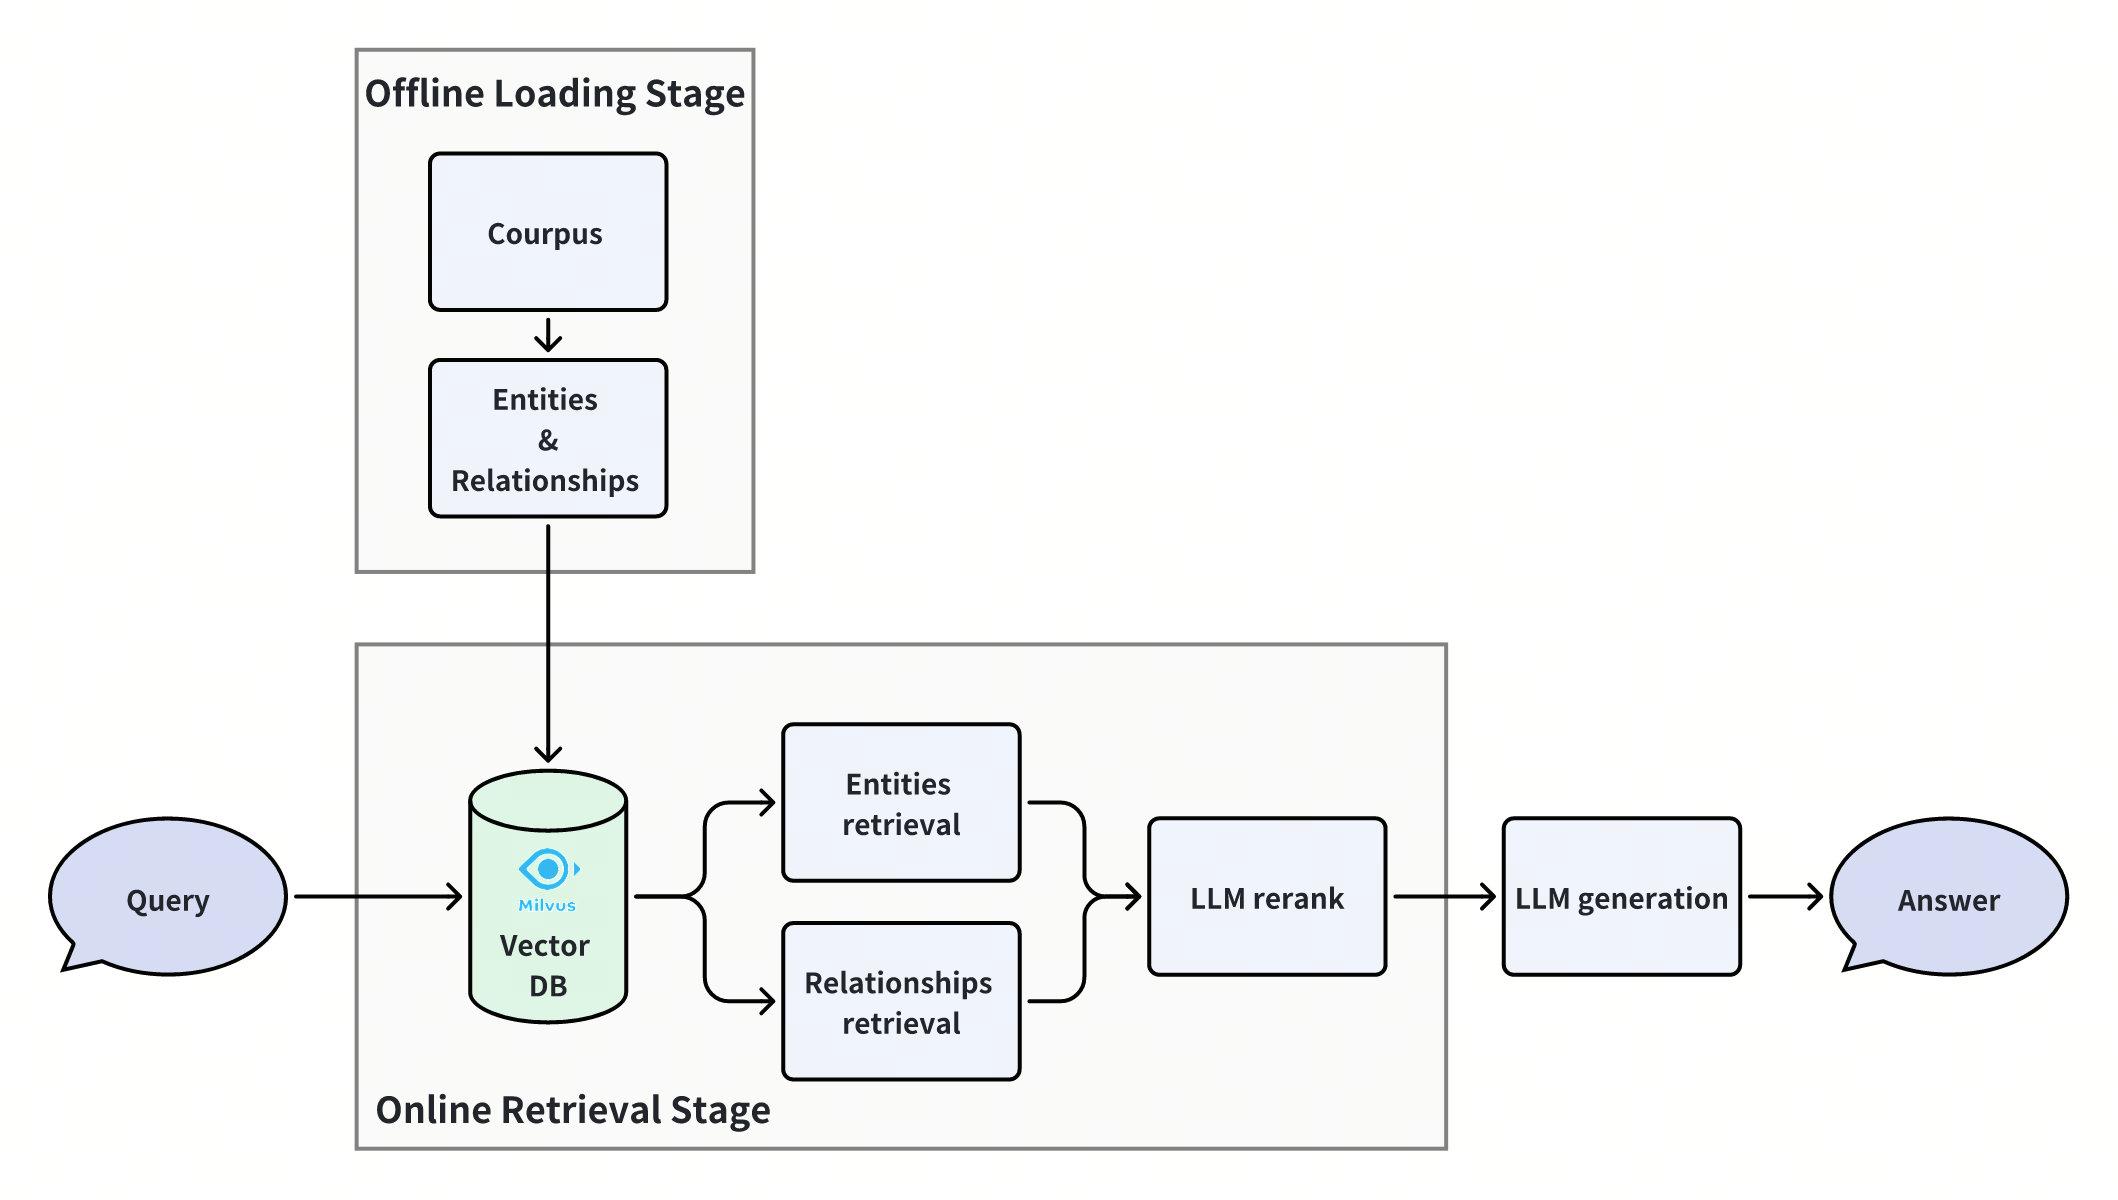

## Required Packages

---

In [2]:
import os
from collections import defaultdict

import numpy as np
from scipy.sparse import csr_matrix
from pymilvus import MilvusClient
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from tqdm import tqdm
from dotenv import load_dotenv

In [3]:
# load .env
load_dotenv()

os.environ["OPENAI_API_KEY"] = os.environ.get('OPENAI_API_KEY')

In [4]:
uri = "http://localhost:19530"
milvus_client = MilvusClient(uri=uri)

llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
)
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

## Offline Data Loading

---

### Data Preparation

The relationship between Bernoulli family and Euler

In [5]:
nano_dataset = [
    {
        "passage": "Jakob Bernoulli (1654–1705): Jakob was one of the earliest members of the Bernoulli family to gain prominence in mathematics. He made significant contributions to calculus, particularly in the development of the theory of probability. He is known for the Bernoulli numbers and the Bernoulli theorem, a precursor to the law of large numbers. He was the older brother of Johann Bernoulli, another influential mathematician, and the two had a complex relationship that involved both collaboration and rivalry.",
        "triplets": [
            ["Jakob Bernoulli", "made significant contributions to", "calculus"],
            [
                "Jakob Bernoulli",
                "made significant contributions to",
                "the theory of probability",
            ],
            ["Jakob Bernoulli", "is known for", "the Bernoulli numbers"],
            ["Jakob Bernoulli", "is known for", "the Bernoulli theorem"],
            ["The Bernoulli theorem", "is a precursor to", "the law of large numbers"],
            ["Jakob Bernoulli", "was the older brother of", "Johann Bernoulli"],
        ],
    },
    {
        "passage": "Johann Bernoulli (1667–1748): Johann, Jakob’s younger brother, was also a major figure in the development of calculus. He worked on infinitesimal calculus and was instrumental in spreading the ideas of Leibniz across Europe. Johann also contributed to the calculus of variations and was known for his work on the brachistochrone problem, which is the curve of fastest descent between two points.",
        "triplets": [
            [
                "Johann Bernoulli",
                "was a major figure of",
                "the development of calculus",
            ],
            ["Johann Bernoulli", "was", "Jakob's younger brother"],
            ["Johann Bernoulli", "worked on", "infinitesimal calculus"],
            ["Johann Bernoulli", "was instrumental in spreading", "Leibniz's ideas"],
            ["Johann Bernoulli", "contributed to", "the calculus of variations"],
            ["Johann Bernoulli", "was known for", "the brachistochrone problem"],
        ],
    },
    {
        "passage": "Daniel Bernoulli (1700–1782): The son of Johann Bernoulli, Daniel made major contributions to fluid dynamics, probability, and statistics. He is most famous for Bernoulli’s principle, which describes the behavior of fluid flow and is fundamental to the understanding of aerodynamics.",
        "triplets": [
            ["Daniel Bernoulli", "was the son of", "Johann Bernoulli"],
            ["Daniel Bernoulli", "made major contributions to", "fluid dynamics"],
            ["Daniel Bernoulli", "made major contributions to", "probability"],
            ["Daniel Bernoulli", "made major contributions to", "statistics"],
            ["Daniel Bernoulli", "is most famous for", "Bernoulli’s principle"],
            [
                "Bernoulli’s principle",
                "is fundamental to",
                "the understanding of aerodynamics",
            ],
        ],
    },
    {
        "passage": "Leonhard Euler (1707–1783) was one of the greatest mathematicians of all time, and his relationship with the Bernoulli family was significant. Euler was born in Basel and was a student of Johann Bernoulli, who recognized his exceptional talent and mentored him in mathematics. Johann Bernoulli’s influence on Euler was profound, and Euler later expanded upon many of the ideas and methods he learned from the Bernoullis.",
        "triplets": [
            [
                "Leonhard Euler",
                "had a significant relationship with",
                "the Bernoulli family",
            ],
            ["leonhard Euler", "was born in", "Basel"],
            ["Leonhard Euler", "was a student of", "Johann Bernoulli"],
            ["Johann Bernoulli's influence", "was profound on", "Euler"],
        ],
    },
]

In [6]:
entityid_2_relationids = defaultdict(list)
relationid_2_passageids = defaultdict(list)

entities = []
relations = []
passages = []
for passage_id, dataset_info in enumerate(nano_dataset):
    passage, triplets = dataset_info["passage"], dataset_info["triplets"]
    passages.append(passage)
    for triplet in triplets:
        if triplet[0] not in entities:
            entities.append(triplet[0])
        if triplet[2] not in entities:
            entities.append(triplet[2])
        relation = " ".join(triplet)
        if relation not in relations:
            relations.append(relation)
            entityid_2_relationids[entities.index(triplet[0])].append(len(relations) - 1)
            entityid_2_relationids[entities.index(triplet[2])].append(len(relations) - 1)
        relationid_2_passageids[relations.index(relation)].append(passage_id)

In [7]:
entityid_2_relationids

defaultdict(list,
            {0: [0, 1, 2, 3, 5],
             1: [0],
             2: [1],
             3: [2],
             4: [3],
             5: [4],
             6: [4],
             7: [5, 6, 7, 8, 9, 10, 11, 12, 20],
             8: [6],
             9: [7],
             10: [8],
             11: [9],
             12: [10],
             13: [11],
             14: [12, 13, 14, 15, 16],
             15: [13],
             16: [14],
             17: [15],
             18: [16, 17],
             19: [17],
             20: [18, 20],
             21: [18],
             22: [19],
             23: [19],
             24: [21],
             25: [21]})

In [8]:
relationid_2_passageids

defaultdict(list,
            {0: [0],
             1: [0],
             2: [0],
             3: [0],
             4: [0],
             5: [0],
             6: [1],
             7: [1],
             8: [1],
             9: [1],
             10: [1],
             11: [1],
             12: [2],
             13: [2],
             14: [2],
             15: [2],
             16: [2],
             17: [2],
             18: [3],
             19: [3],
             20: [3],
             21: [3]})

### Data Insertion

In [10]:
embedding_dim = len(embedding_model.embed_query("foo"))
embedding_dim

1536

In [11]:
def create_milvus_collection(collection_name: str):
    if milvus_client.has_collection(collection_name=collection_name):
        milvus_client.drop_collection(collection_name=collection_name)
    milvus_client.create_collection(
        collection_name=collection_name,
        dimension=embedding_dim,
        consistency_level="Bounded",  # Supported values are (`"Strong"`, `"Session"`, `"Bounded"`, `"Eventually"`). See https://milvus.io/docs/consistency.md#Consistency-Level for more details.
    )

In [12]:
entity_col_name = "entity_collection"
relation_col_name = "relation_collection"
passage_col_name = "passage_collection"
create_milvus_collection(entity_col_name)
create_milvus_collection(relation_col_name)
create_milvus_collection(passage_col_name)

In [13]:
def milvus_insert(
    collection_name: str,
    text_list: list[str],
):
    batch_size = 512
    for row_id in tqdm(range(0, len(text_list), batch_size), desc="Inserting"):
        batch_texts = text_list[row_id : row_id + batch_size]
        batch_embeddings = embedding_model.embed_documents(batch_texts)

        batch_ids = [row_id + j for j in range(len(batch_texts))]
        batch_data = [
            {
                "id": id_,
                "text": text,
                "vector": vector,
            }
            for id_, text, vector in zip(batch_ids, batch_texts, batch_embeddings)
        ]
        milvus_client.insert(
            collection_name=collection_name,
            data=batch_data,
        )

In [14]:
milvus_insert(
    collection_name=relation_col_name,
    text_list=relations,
)

milvus_insert(
    collection_name=entity_col_name,
    text_list=entities,
)

milvus_insert(
    collection_name=passage_col_name,
    text_list=passages,
)

Inserting: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


## Online Querying

---

### Similarity Retrieval